<a href="https://colab.research.google.com/github/brenoakihiromorimoto/portf-lio/blob/main/%237DaysOfCode/dia_6_Teste_AB_e_Teste_de_Hip%C3%B3tese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#7DaysOfCode - Ciência de Dados 6/7: 👩🏽‍💻 Teste A/B e Testes de Hipótese
Você chegou ao penúltimo dia do #7DaysOfCode de Dados!

Parabéns pelo que construiu até aqui. Tudo certo para mais um desafio?

Vamos supor que você trabalha para um e-commerce, e que você criou um sistema de recomendação que irá apresentar melhores produtos para os clientes e, consequentemente, aumentar as vendas do site.

Como você testa se o seu modelo é melhor que a versão atual do site, sem sistema de recomendação?

Uma abordagem muito comum utilizada por designers, gerentes de produto e cientistas de dados é o chamado Teste A/B, do Inglês A/B Testing, ou Split Testing.

Basicamente, você distribui duas versões do seu site aleatoriamente para seus usuários e calcula uma métrica de sucesso (neste caso, a Taxa de Aprovação) para ambas as versões. A versão que tiver os melhores resultados na métrica de sucesso, é a melhor versão do seu teste.

O Teste A/B é apenas um exemplo de uma das atividades mais comuns de um cientista de dados: a validação de hipóteses.

Basicamente, o que se busca com esse teste é validar ou refutar uma hipótese bem definida: que seu site fica melhor com o sistema de recomendação. E, enquanto o Teste A/B é apenas um método, o fator mais importante nessa validação é o teste de hipótese que você irá utilizar.

Vamos simular que você já executou o Teste A/B e que está com o dataset com os resultados em mãos.

Esse dataset disponível no Kaggle simula os resultados de um teste. Você verá que ele contém colunas como a identificação do usuário, a versão do site ao qual ele foi exposto, e se ele converteu (realizou uma compra) ou não.

Esse dataset possui também um campo de data, que te permitirá analisar como esse teste se comportou ao longo do tempo.

Para esse exercício, eu te desafio a baixar esse dataset e executar um teste de hipótese nele para validar se a versão nova do site (com o sistema de recomendação) é melhor que a antiga.

# Importar bibliotecas

In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
from scipy.stats import shapiro, mannwhitneyu, ttest_ind, levene

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


# Diagrama do processo de teste A/B

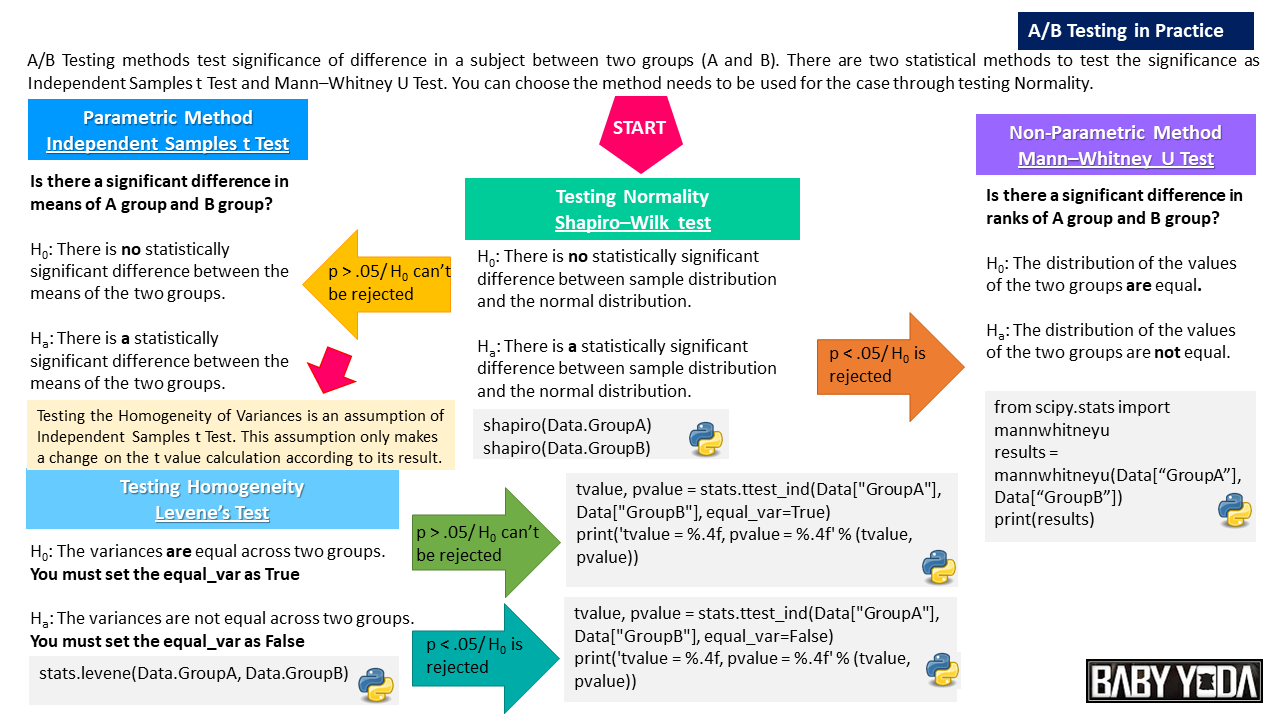

# Importar dataset

In [5]:
df_teste_ab = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/#7DaysOfCode/ab_data.csv', sep=',')

# Teste de hipótese

* Dois dados serão importantes para saber se a nova página é melhor que a velha página: 
  * **converted**
  * **landing_page**

In [9]:
df_teste_ab.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


* Qual é o percentual de conversões?

In [20]:
df_teste_ab[['landing_page', 'converted']].groupby('landing_page').agg(['sum'])/len(df_teste_ab['converted'])*100

,converted
,sum
landing_page,
new_page,5.94204
old_page,6.02388


* A nova página converteu 5.94% dos usuários.
* A antiga página converteu 6.02% dos usuários.
* Essa diferença é significativa?

# Passo 0: estabelecer tamanho da amostra

* Irei estabelecer um número de amostra de 5000 com random_state=0.

In [90]:
df_teste_ab = df_teste_ab.sample(5000, random_state=0)

# Passo 1: verificar distribuições dos dados

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


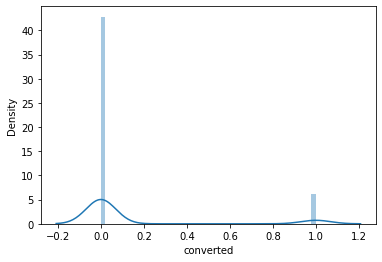

In [296]:
sns.distplot(df_teste_ab[df_teste_ab['landing_page']=='new_page']['converted'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


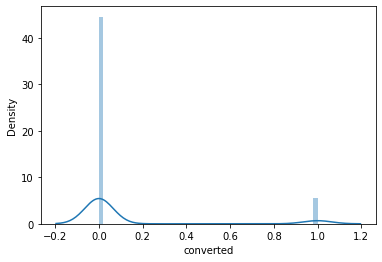

In [297]:
sns.distplot(df_teste_ab[df_teste_ab['landing_page']=='old_page']['converted'])

**Qual foi o problema desse teste de hipótese**
* O problema desse dataset é que as distribuições ficaram binomiais já que cada linha do dataset é um cliente, isso irá criar uma distorção no teste de hipótese.
* É necessário agrupar por data e somar as conversões de acordo com a versão do site para ter uma única distribuição de conversões para cada grupo.

# Fazer teste de hipótese com dataset modificado.

* Criar a coluna mes e dia.

In [126]:
df_teste_ab['dia'] = df_teste_ab['timestamp'].str[8:10].astype(int)
df_teste_ab['mes'] = df_teste_ab['timestamp'].str[5:7].astype(int)

## Agrupar conversão de clientes por dia.

* Quantos meses únicos têm no dataset?

In [194]:
df_teste_ab.mes.nunique()

1

* A amostra aconteceu em um único mês, o que possibilita agruparmos os dados por dia, assim será possível analisar as distribuições de forma mais precisa.

In [249]:
df_teste_ab_dia = df_teste_ab[df_teste_ab['landing_page']=='new_page'][['dia', 'landing_page', 'converted']]\
.groupby('dia').agg({'landing_page':'unique', 'converted':'sum'}).reset_index()

In [250]:
df_teste_ab_dia = df_teste_ab_dia.append(df_teste_ab[df_teste_ab['landing_page']=='old_page'][['dia', 'landing_page', 'converted']]\
.groupby('dia').agg({'landing_page':'unique', 'converted':'sum'}).reset_index())

In [251]:
df_teste_ab_dia['landing_page'] = df_teste_ab_dia['landing_page']

In [286]:
df_teste_ab_dia['landing_page'] = [list(x)[0] for x in df_teste_ab_dia['landing_page']]

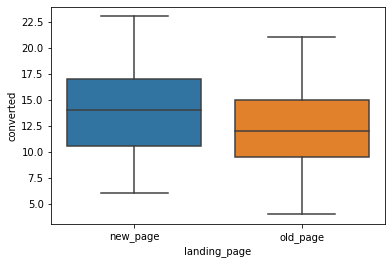

In [287]:
sns.boxplot(data=df_teste_ab_dia, x='landing_page', y='converted')

* Ow! O novo site teve mais conversões na mediana que o antigo site! Irei aplicar testes de hipótese para saber se essa diferença é significativa ou não.

## Passo 2: teste de normalidade por Shapiro-Wilk.

In [291]:
stats, p = shapiro(df_teste_ab_dia[df_teste_ab_dia['landing_page']=='new_page']['converted'])
print('stats: %.3f, valor-p: %.3f' % (stats, p))

stats: 0.973, valor-p: 0.758


* O valor p>=0.05 significa que a distribuição da nova página é normal. 

In [293]:
stats, p = shapiro(df_teste_ab_dia[df_teste_ab_dia['landing_page']=='old_page']['converted'])
print('stats: %.3f, valor-p: %.3f' % (stats, p))

stats: 0.985, valor-p: 0.967


* O valor p>=0.05 significa que a distribuição da antiga página é normal.

## Passo 3: teste de homogeneidade por teste de Levene

In [303]:
stats, p = levene(df_teste_ab_dia[df_teste_ab_dia['landing_page']=='old_page']['converted'],
                     df_teste_ab_dia[df_teste_ab_dia['landing_page']=='new_page']['converted'])
print('stats: %.3f, valor-p: %.3f' % (stats, p))

stats: 0.003, valor-p: 0.955


* No teste de levene, o p-valor foi >0.05, o que significa que a variância é igual nos dois grupos.

## Passo 4: teste t independente

* Sendo a variância igual nos dois grupos, é necessário colocar **equal_var=True**.

In [306]:
stats, p = ttest_ind(df_teste_ab_dia[df_teste_ab_dia['landing_page']=='old_page']['converted'],
                     df_teste_ab_dia[df_teste_ab_dia['landing_page']=='new_page']['converted'], equal_var=True)
print('stats: %.3f, valor-p: %.3f' % (stats, p))

stats: -1.313, valor-p: 0.196


* De acordo com o teste-t independente, o valor-p foi maior que 0.05, o que significa diferença estatisticamente significativa da média dos dois grupos. 

## Conclusão

* **A diferença entre as versões dos sites não foi significativa.**
* Ambos tiveram um desempenho igual.
* Será que existe uma diferença na tendência de conversões entre os dois grupos?

# Tendência

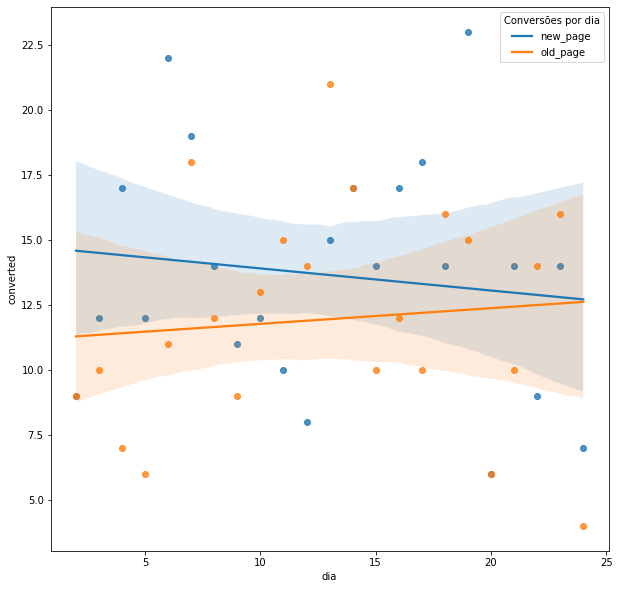

In [347]:
ax = plt.figure(figsize=(10,10))
ax = sns.regplot(data=df_teste_ab_dia[df_teste_ab_dia['landing_page']=='new_page'].sort_values(by='dia'), 
                 x='dia', y='converted', label='new_page')
ax = sns.regplot(data=df_teste_ab_dia[df_teste_ab_dia['landing_page']=='old_page'].sort_values(by='dia'), 
                 x='dia', y='converted', label='old_page')
plt.legend(title = 'Conversões por dia', labels=['new_page', 'old_page'])

* Mesmo que no teste de hipótese consideramos analisar uma distribuição normal, observamos uma tendência de crescimento de conversões da página antiga, enquanto a nova página tende a diminuir o número de conversões.

# Conclusão

* Por mais que as duas versões tiveram médias iguais de acordo com o teste de hipótese, os dois sites têm tendências opostas, o site antigo tem tendência de crescer as conversões, e o novo site tem tendência de diminuir as conversões.

**O site com melhor desempenho de conversões é o antigo.**